Epoch 1/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.1031 - loss: 3.7017 - val_accuracy: 0.1044 - val_loss: 2.8109 - learning_rate: 1.0000e-04
Epoch 2/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1057 - loss: 2.6753 - val_accuracy: 0.1334 - val_loss: 2.4150 - learning_rate: 1.0000e-04
Epoch 3/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1483 - loss: 2.3396 - val_accuracy: 0.1754 - val_loss: 2.1544 - learning_rate: 1.0000e-04
Epoch 4/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1791 - loss: 2.1558 - val_accuracy: 0.1855 - val_loss: 2.1204 - learning_rate: 1.0000e-04
Epoch 5/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1941 - loss: 2.1242 - val_accuracy: 0.2021 - val_loss: 2.0947 - learning_rate: 1.0000e-04
Epoch 6/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2037 - loss: 2.1042 - val_accuracy: 0.2124 - val_loss: 2.0742 - learning_rate: 1.0000e-04
Epoch 7/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - acc

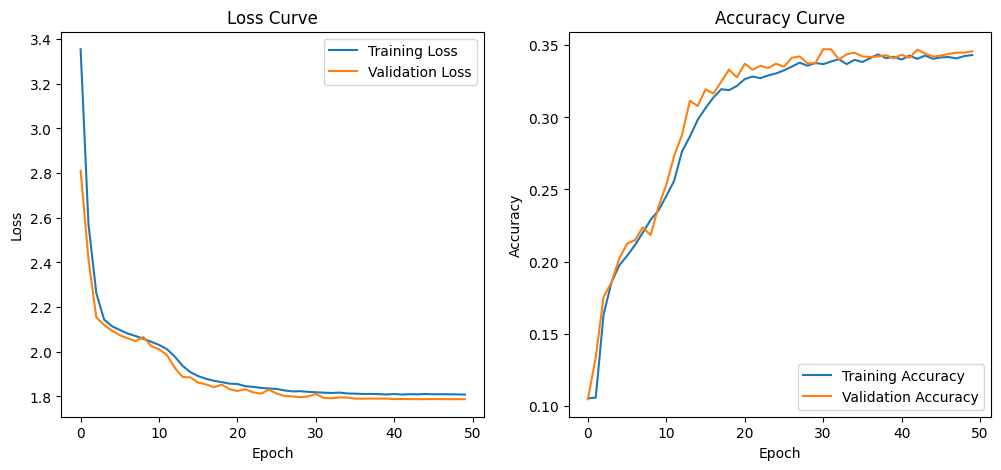

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3405 - loss: 1.8226 
Test Loss: 1.8193
Test Accuracy: 0.3393
✅ CNN + LSTM モデルの学習が完了しました。


In [2]:
import os
import numpy as np
import tensorflow as tf
import librosa
import librosa.display
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 🚀 データ保存先
DATA_DIR = "./data/"

# 🚀 特徴量とラベルをロード
features_path = os.path.join(DATA_DIR, "processed_features.npy")
labels_path = os.path.join(DATA_DIR, "processed_labels.npy")
X = np.load(features_path)
y = np.load(labels_path)

# 🚀 ラベルを one-hot encoding 形式に変換
if len(y.shape) == 1:
    y = to_categorical(y)

# 🚀 データの正規化
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# 🚀 データの分割
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1))
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1))

# 🚀 CNN + LSTM の入力形状変更
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 🚀 CNN + LSTM モデル構築
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),  

    # 🚀 CNN（畳み込み層）
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),

    # 🚀 LSTM（長短期記憶ネットワーク）
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.002))),
    Dropout(0.4),
    Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.002))),
    Dropout(0.4),

    # 🚀 全結合層
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  
])

# 🚀 モデルのコンパイル
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 🚀 EarlyStopping と ReduceLROnPlateau の適用
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# 🚀 モデルの学習
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

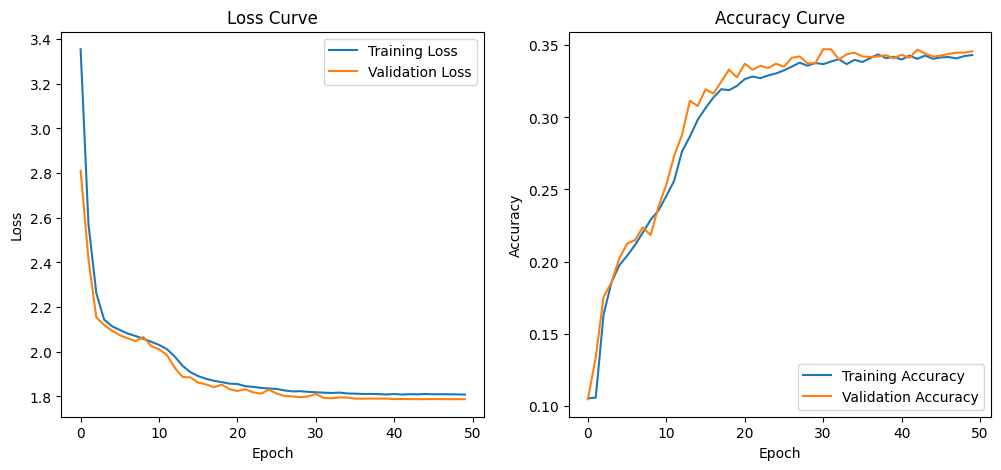

In [4]:
# 🚀 学習曲線の可視化
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

In [3]:
# 🚀 モデルの評価
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 🚀 モデルの保存（`.keras` 形式に統一）
model.save(os.path.join(DATA_DIR, "cnn_lstm_model.keras"))  
print("✅ CNN + LSTM モデルの学習が完了しました。")

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3405 - loss: 1.8226 
Test Loss: 1.8193
Test Accuracy: 0.3393
✅ CNN + LSTM モデルの学習が完了しました。


Epoch 1/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.1077 - loss: 4.0456 - val_accuracy: 0.1988 - val_loss: 2.2340 - learning_rate: 3.0000e-04
Epoch 2/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.2162 - loss: 2.1369 - val_accuracy: 0.2391 - val_loss: 2.0175 - learning_rate: 3.0000e-04
Epoch 3/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.2462 - loss: 2.0047 - val_accuracy: 0.2719 - val_loss: 1.9426 - learning_rate: 3.0000e-04
Epoch 4/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.2799 - loss: 1.9347 - val_accuracy: 0.2976 - val_loss: 1.8794 - learning_rate: 3.0000e-04
Epoch 5/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3153 - loss: 1.8794 - val_accuracy: 0.3322 - val_loss: 1.8394 - learning_rate: 3.0000e-04
Epoch 6/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3398 - loss: 1.8359 - val_accuracy: 0.3393 - val_loss: 1.8094 - learning_rate: 3.0000e-04
Epoch 7/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - acc

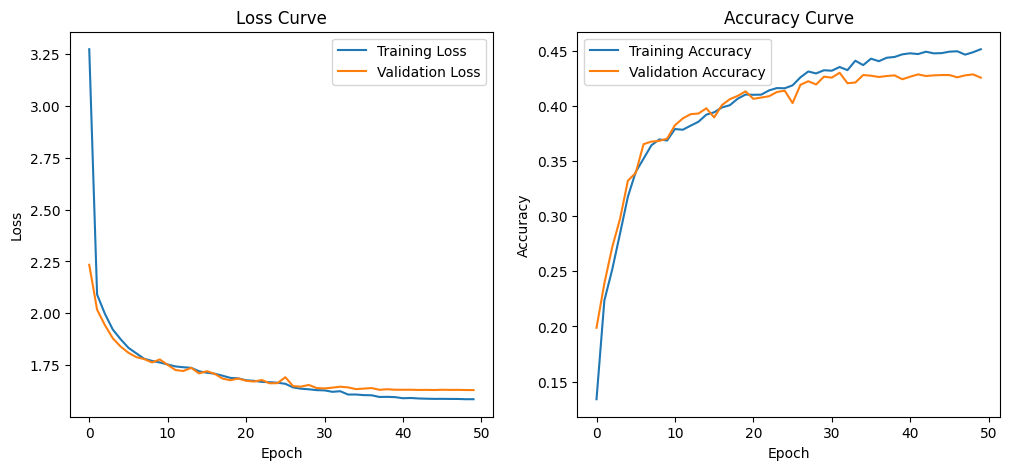

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4177 - loss: 1.6796 
Test Loss: 1.6824
Test Accuracy: 0.4098
✅ CNN + LSTM 改善版の学習が完了しました。


In [5]:
import os
import numpy as np
import tensorflow as tf
import librosa
import librosa.display
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 🚀 データ保存先
DATA_DIR = "./data/"

# 🚀 特徴量とラベルをロード
features_path = os.path.join(DATA_DIR, "processed_features.npy")
labels_path = os.path.join(DATA_DIR, "processed_labels.npy")
X = np.load(features_path)
y = np.load(labels_path)

# 🚀 ラベルを one-hot encoding 形式に変換
if len(y.shape) == 1:
    y = to_categorical(y)

# 🚀 データの正規化
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# 🚀 データの分割
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1))
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1))

# 🚀 CNN + LSTM の入力形状変更
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 🚀 CNN + LSTM モデル構築（改善版）
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),  

    # 🚀 CNN（畳み込み層） → フィルターサイズを 5 に拡大
    Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),

    # 🚀 LSTM（長短期記憶ネットワーク） → ユニット数を増加
    Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.002))),
    Dropout(0.4),
    Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.002))),
    Dropout(0.4),

    # 🚀 全結合層
    Dense(128, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  
])

# 🚀 Optimizer の Learning Rate を調整（0.0003 に増加）
model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

# 🚀 EarlyStopping と ReduceLROnPlateau の適用
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# 🚀 モデルの学習
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,  # バッチサイズを 128 に増加
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# 🚀 学習曲線の可視化
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# 🚀 モデルの評価
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 🚀 モデルの保存（`.keras` 形式に統一）
model.save(os.path.join(DATA_DIR, "cnn_lstm_model_v2.keras"))  
print("✅ CNN + LSTM 改善版の学習が完了しました。")
